In [1]:
# to avoid errors on loading missingpy
import pandas as pd
import numpy as np
import sys
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import metrics
# With missforest we can use random forest to impute data. This is better than mean by far
from missingpy import MissForest
import lightgbm as lgb

# load stored data from EDA and cleaning Nan
%store -r data_frame_clean
train_df = data_frame_clean.copy()

## Label encoder to categorical columns

This is done so we can apply algorithms either to impute or to predict to our dataset

In [2]:
# taking a look to categorical variables
cat_vars = train_df.select_dtypes(exclude=[np.number])
cat_vars.describe()

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
count,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,...,1460,1460,770,1379,1379,1379,1379,1460,1460,1460
unique,5,2,4,4,2,5,3,25,9,8,...,4,7,5,6,3,5,5,3,9,6
top,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,...,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,WD,Normal
freq,1151,1454,925,1311,1459,1052,1382,225,1260,1445,...,735,1360,380,870,605,1311,1326,1340,1267,1198


In [3]:
# process columns, apply LabelEncoder to categorical features
for c in cat_vars.columns:
    lbl = LabelEncoder() 
    lbl.fit(list(train_df[c].values)) 
    train_df[c] = lbl.transform(list(train_df[c].values))

## Impute categorical data with Random forest algorithm

In [4]:
# I need to get an example with real data.
# Make an instance and perform the imputation
imputer = MissForest(max_iter = 10, max_features=1.0, criterion='squared_error')
train_df_temp = train_df.drop('SalePrice', axis=1)
train_df_imputed = pd.DataFrame(imputer.fit_transform(train_df_temp))

# Renaming columns after imputation and add back the variable to predict
train_df_imputed = train_df_imputed.merge(train_df['SalePrice'], left_index = True, right_index= True)
train_df_imputed.columns = train_df.columns

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


## Testing lightgbm

In [7]:
# getting ready x and y variables
x = train_df_imputed.drop(['Id','SalePrice'],axis=1)
y = train_df_imputed.SalePrice

# train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, random_state = 42)

In [19]:
# build the lightgbm model

model = lgb.LGBMRegressor(learning_rate=0.09,max_depth=-5,random_state=42) # lgb.LGBMClassifier() or LGBMRanker()
model.fit(x_train,y_train,eval_set=[(x_train,y_train), (x_test,y_test)],
          eval_metric='logloss')

[1]	training's l2: 4.98119e+09	valid_1's l2: 6.39683e+09
[2]	training's l2: 4.30386e+09	valid_1's l2: 5.62658e+09
[3]	training's l2: 3.73323e+09	valid_1's l2: 4.97702e+09
[4]	training's l2: 3.24527e+09	valid_1's l2: 4.42677e+09
[5]	training's l2: 2.83025e+09	valid_1's l2: 3.93429e+09
[6]	training's l2: 2.48533e+09	valid_1's l2: 3.53538e+09
[7]	training's l2: 2.18635e+09	valid_1's l2: 3.16439e+09
[8]	training's l2: 1.94013e+09	valid_1's l2: 2.88058e+09
[9]	training's l2: 1.73221e+09	valid_1's l2: 2.64705e+09
[10]	training's l2: 1.54923e+09	valid_1's l2: 2.42304e+09
[11]	training's l2: 1.39676e+09	valid_1's l2: 2.24646e+09
[12]	training's l2: 1.25851e+09	valid_1's l2: 2.09509e+09
[13]	training's l2: 1.14316e+09	valid_1's l2: 1.95675e+09
[14]	training's l2: 1.04265e+09	valid_1's l2: 1.84681e+09
[15]	training's l2: 9.59668e+08	valid_1's l2: 1.75372e+09
[16]	training's l2: 8.85481e+08	valid_1's l2: 1.64921e+09
[17]	training's l2: 8.2439e+08	valid_1's l2: 1.57741e+09
[18]	training's l2: 7.69

LGBMRegressor(learning_rate=0.09, max_depth=-5, random_state=42)

In [20]:
print('Training accuracy {:.4f}'.format(model.score(x_train,y_train)))
print('Testing accuracy {:.4f}'.format(model.score(x_test,y_test)))

Training accuracy 0.9797
Testing accuracy 0.8699



Bad key figure.labelsize in file /Users/hectorcozar/Documents/GitHub/templates/venv/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/classic 2.mplstyle, line 310 ('figure.labelsize:   medium    # size of the figure label')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key figure.labelweight in file /Users/hectorcozar/Documents/GitHub/templates/venv/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/classic 2.mplstyle, line 311 ('figure.labelweight: normal    # weight of the figure label')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

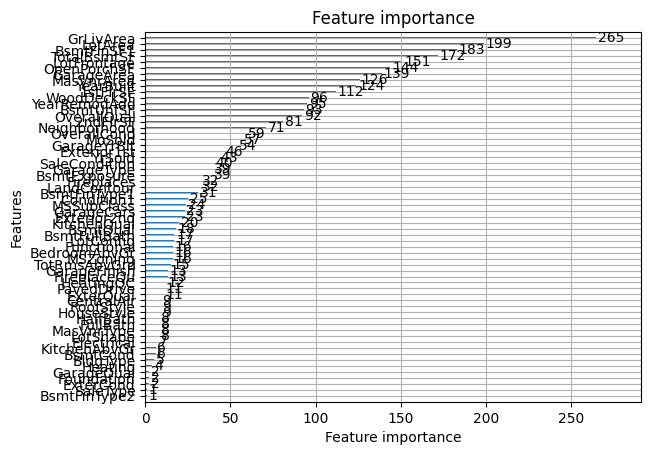

In [21]:
lgb.plot_importance(model)


<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='l2'>

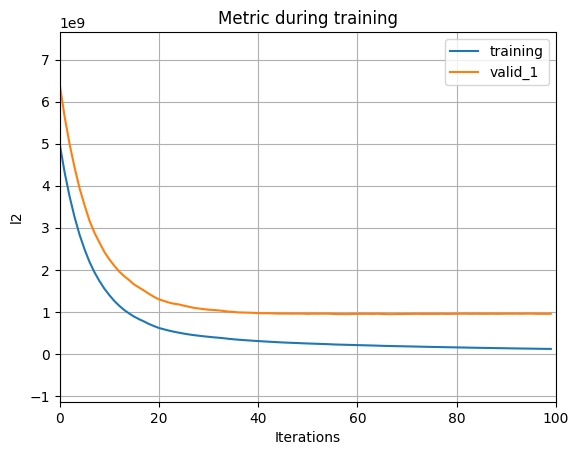

In [22]:
lgb.plot_metric(model)


ImportError: You must install graphviz and restart your session to plot tree.

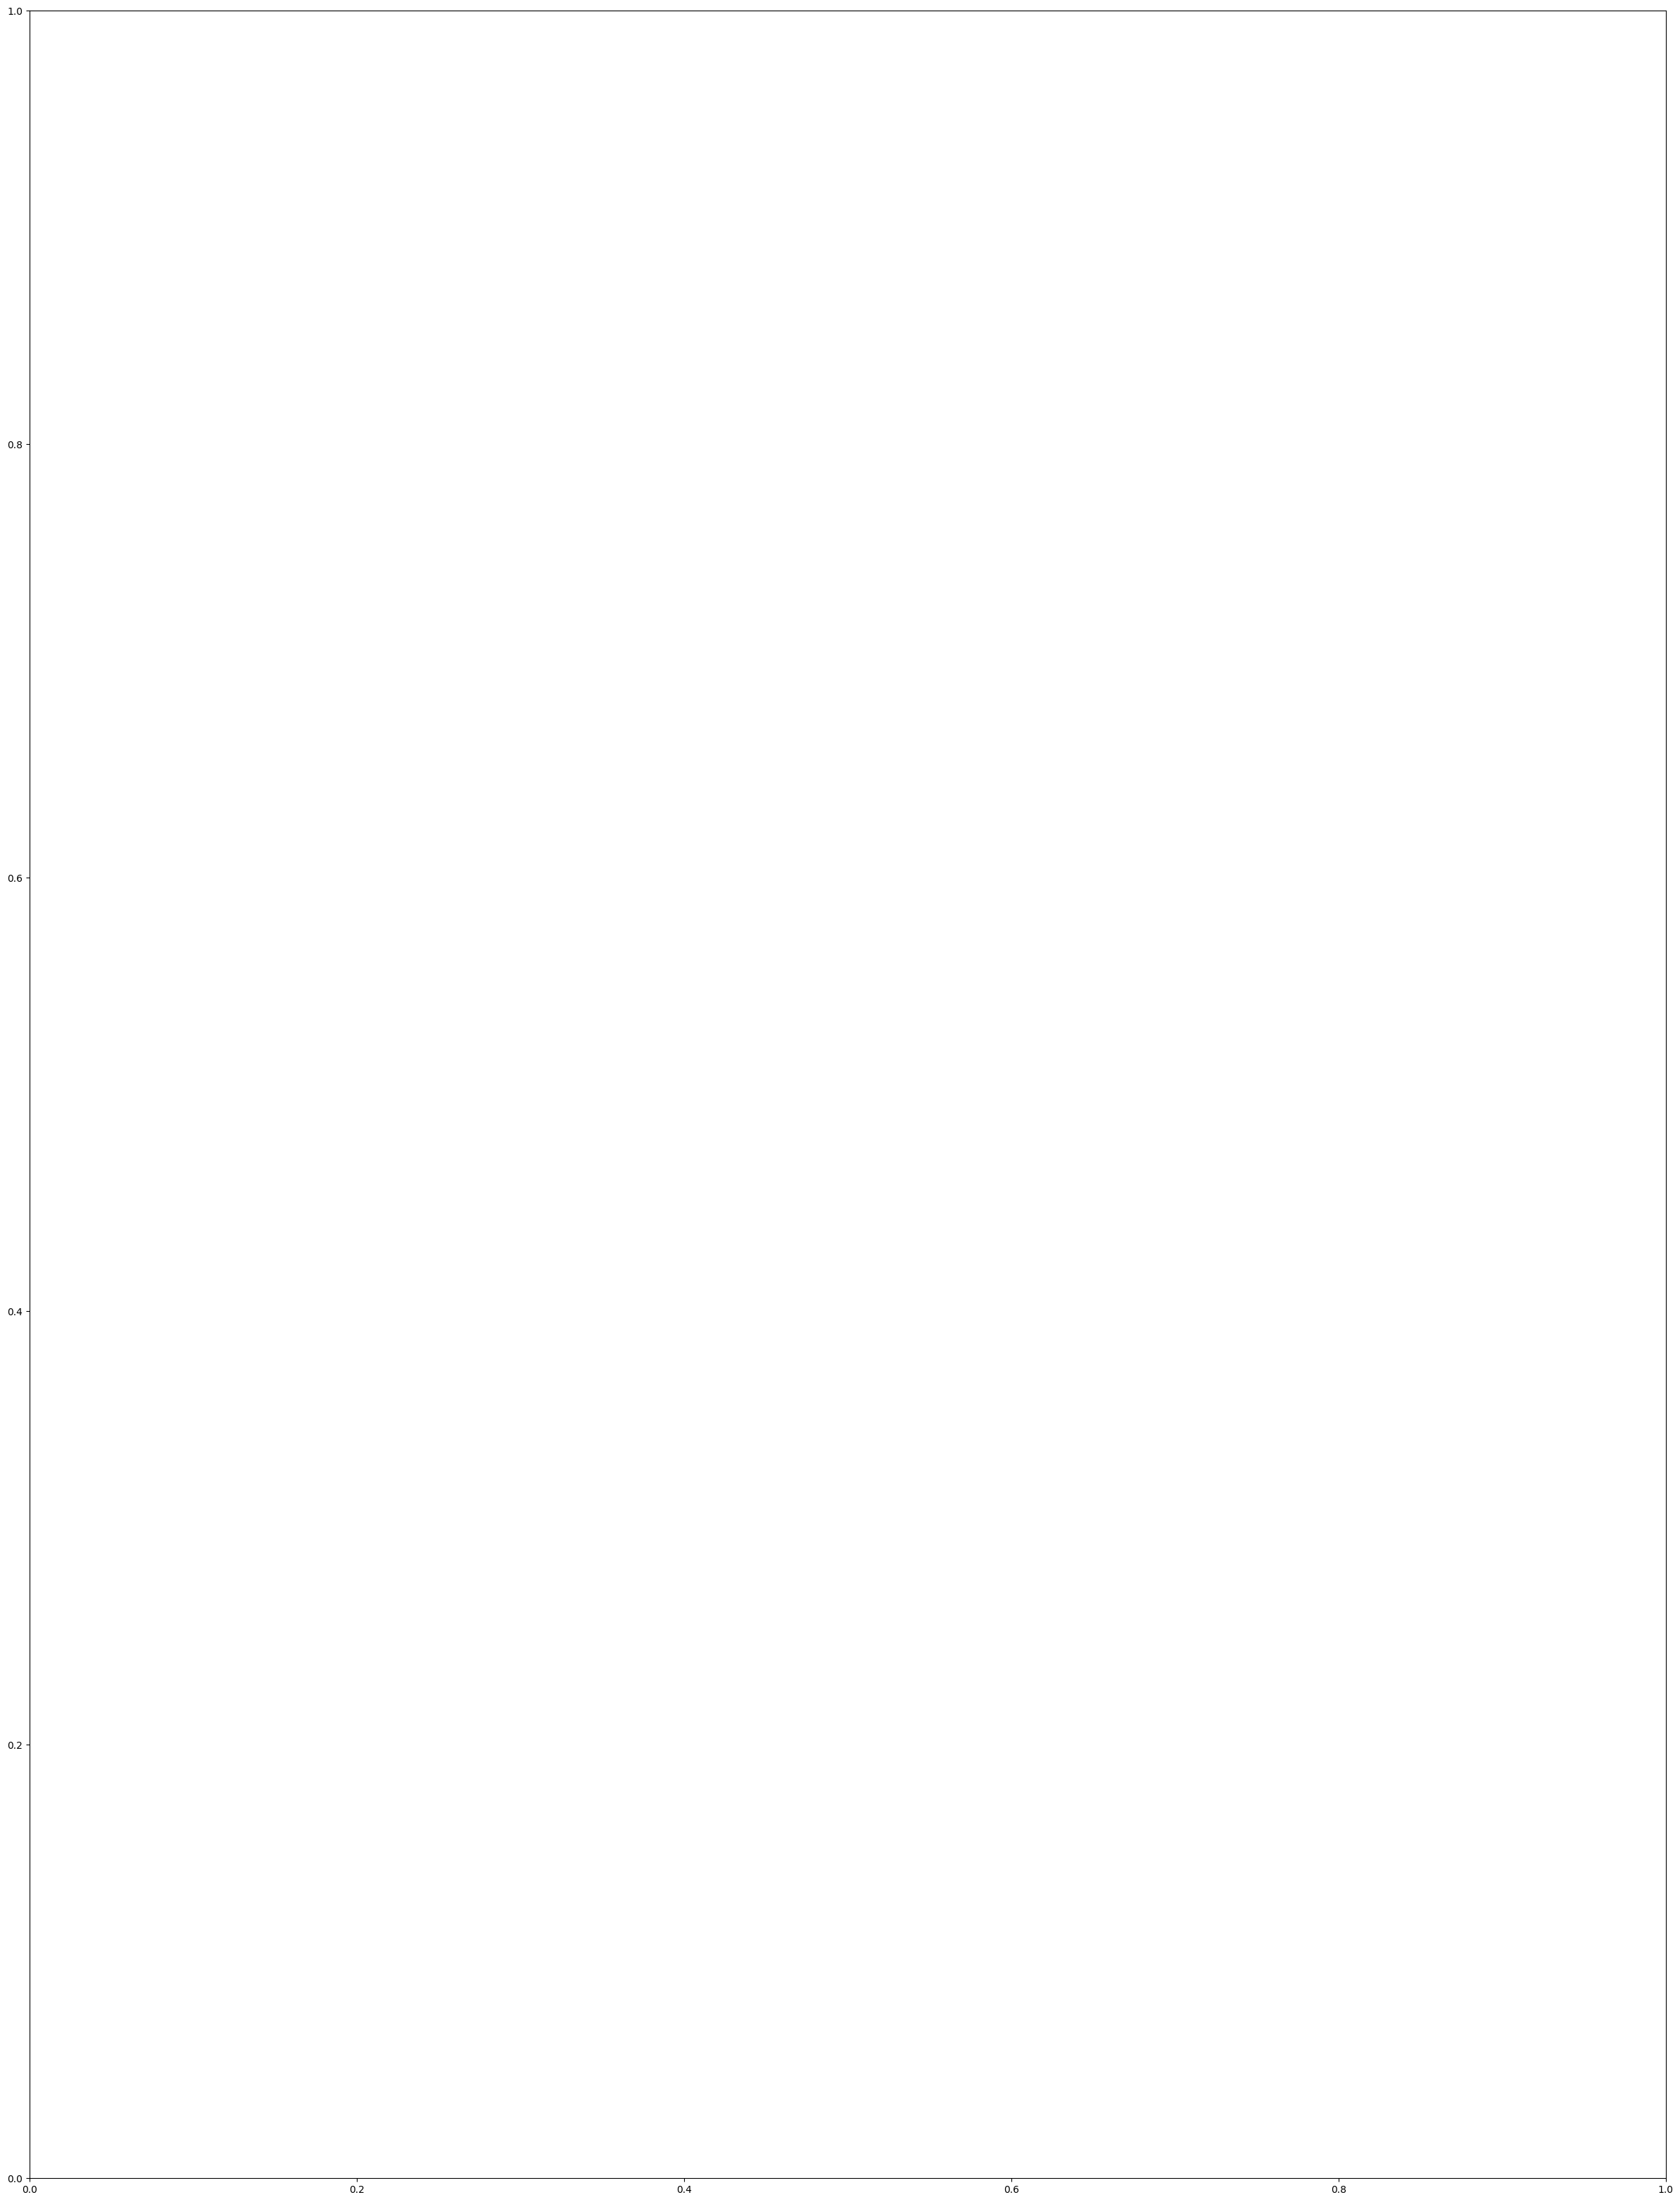

In [23]:
lgb.plot_tree(model,figsize=(30,40))


In [ ]:
metrics.plot_confusion_matrix(model,x_test,y_test,cmap='Blues_r')


In [ ]:
print(metrics.classification_report(y_test,model.predict(x_test)))


In [14]:
# build the lightgbm model
clf = lgb.LGBMClassifier()
clf.fit(x_train, y_train)

ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in the following fields: MSZoning, Street, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, Heating, HeatingQC, CentralAir, Electrical, KitchenQual, Functional, FireplaceQu, GarageType, GarageFinish, GarageQual, GarageCond, PavedDrive, SaleType, SaleCondition

In [10]:
#setting up the model
model = lgb.LGBMClassifier(learning_rate = 0.09, max_depth = -5, random_state = 42)
model.fit(x_train, y_train, eval_set = [(x_test, y_test), (x_train, y_train)],
          verbose = 20, eval_metric = 'logloss')

ValueError: y contains previously unseen labels: [35311, 40000, 55993, 62383, 64500, 66500, 67000, 68400, 68500, 75000, 75500, 79500, 84900, 85400, 87500, 89471, 90350, 91300, 92000, 93500, 94000, 101800, 102776, 103200, 104000, 105500, 105900, 107900, 108480, 108959, 109008, 116050, 118400, 118858, 121500, 126175, 126500, 128200, 128950, 130250, 131400, 133500, 134432, 134500, 135500, 135750, 135900, 139900, 144500, 149350, 149500, 150900, 151500, 153337, 153575, 154300, 154500, 154900, 155835, 155900, 156500, 159950, 161500, 164700, 165600, 169990, 172400, 173500, 178900, 181134, 182000, 183500, 183900, 184900, 185750, 185900, 187100, 187750, 192140, 194201, 195400, 200624, 204900, 205950, 206300, 215200, 216000, 217500, 219210, 233170, 238000, 239500, 243000, 244400, 245350, 246578, 253000, 253293, 254000, 254900, 255000, 262000, 263000, 264132, 271900, 274900, 276000, 283463, 284000, 293077, 297000, 301000, 305000, 310000, 311500, 311872, 313000, 314813, 315500, 317000, 318061, 337500, 341000, 348000, 360000, 367294, 369900, 374000, 380000, 395000, 402000, 403000, 423000, 438780, 446261, 451950, 465000, 485000, 556581, 611657, 745000, 755000]